# CNN Model to classify a disease based on the chest x-ray

In [246]:
#importing the necessary libraries
import numpy as np
from numpy import asarray
from array import *

import pandas as pd
import os
import matplotlib.pyplot as plt

from itertools import chain
from PIL import Image
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import array_to_img

%matplotlib inline

Using TensorFlow backend.


In [154]:
plt.rcParams["font.size"] = 30
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.titlesize'] = 20
plt.rcParams["axes.titlesize"] = 20
plt.rcParams["axes.labelsize"] = 20
plt.rcParams["xtick.labelsize"] = 20
plt.rcParams["ytick.labelsize"] = 20
plt.rcParams["legend.fontsize"] = 10

In [155]:
data_entry_file_name = "Data_Entry_2017.csv"
#bbox_list_file_name = "BBox_List_2017.csv"
data_entry_df  = pd.read_csv(data_entry_file_name)
#bbox_df = pd.read_csv(bbox_list_file_name)

In [156]:
data_entry_df

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y]
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143
...,...,...,...,...,...,...,...,...,...,...,...
112115,00030801_001.png,Mass|Pneumonia,1,30801,39,M,PA,2048,2500,0.168,0.168
112116,00030802_000.png,No Finding,0,30802,29,M,PA,2048,2500,0.168,0.168
112117,00030803_000.png,No Finding,0,30803,42,F,PA,2048,2500,0.168,0.168
112118,00030804_000.png,No Finding,0,30804,30,F,PA,2048,2500,0.168,0.168


In [157]:
#let's rename the columns in our dataframe so that it's more compact 
#data_entry_df.rename(columns={"OriginalImage[Width": "ImageWidth", "Height]": "ImageHeight", "OriginalImagePixelSpacing[x": "ImgPixelSpacingX", "y]": "ImgPixelSpacingY"})

In [158]:
data_entry_set = set(data_entry_df['Finding Labels'])
#data_entry_set

It seems that there are a lot of multi-labeled data in our diagnosis. Later we will have to map it out in its separate label so that our model can use it.

In [159]:
data_entry_df['Finding Labels'].value_counts()

No Finding                                                     60361
Infiltration                                                    9547
Atelectasis                                                     4215
Effusion                                                        3955
Nodule                                                          2705
                                                               ...  
Atelectasis|Cardiomegaly|Effusion|Fibrosis|Nodule                  1
Consolidation|Infiltration|Nodule|Pneumonia                        1
Consolidation|Mass|Nodule|Pneumonia                                1
Consolidation|Emphysema|Infiltration|Nodule                        1
Atelectasis|Effusion|Infiltration|Pneumothorax|Cardiomegaly        1
Name: Finding Labels, Length: 836, dtype: int64

In [160]:
data_entry_df[data_entry_df['Patient Age']== 91]

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y]
230,00000049_000.png,Nodule,0,49,91,F,PA,2650,2465,0.143,0.143
581,00000143_005.png,No Finding,5,143,91,M,PA,2500,2048,0.168,0.168
585,00000143_009.png,Atelectasis,9,143,91,M,PA,2992,2991,0.143,0.143
587,00000143_011.png,Atelectasis,11,143,91,M,PA,2992,2991,0.143,0.143
3973,00001085_001.png,Fibrosis|Infiltration|Mass|Pleural_Thickening,1,1085,91,M,PA,2048,2500,0.168,0.168
17750,00004801_001.png,Nodule,1,4801,91,M,PA,2992,2991,0.143,0.143
20851,00005566_012.png,Mass|Pleural_Thickening,12,5566,91,M,PA,2992,2991,0.143,0.143
24615,00006473_000.png,No Finding,0,6473,91,F,PA,2048,2500,0.168,0.168
24616,00006473_001.png,No Finding,1,6473,91,F,PA,2048,2500,0.168,0.168
96724,00025496_000.png,Effusion|Pleural_Thickening,0,25496,91,M,PA,2992,2991,0.143,0.143


Let's see if we can read some of the x-ray images

In [163]:
home_path = os.path.expanduser('~')
git_dir = os.path.join(home_path, "Documents\\WFT\\DataScience\\Git") #for Murad
#git_dir = os.path.join(home_path, "Documents/GitHub") #for Sergazy
nih_dir = os.path.join(git_dir, "NIH-CHEST-XRAY")
data_dir = os.path.join(nih_dir, "data")
train_val_imagelist_file = os.path.join(data_dir, "train_val_list.txt")
images_001_dir = os.path.join(data_dir, "images_001\\images") #for Murad
#images_001_dir = os.path.join(nih_dir, "images") #for Sergazy
images_001_list = []

train_val_file = open(train_val_imagelist_file , 'r')


In [164]:
for line in train_val_file:
    line = line.rstrip("\n")
    #print(type(line))
    file_loc = os.path.join(images_001_dir, line)
    images_001_list.append(file_loc)
    #print(images_001_list)
train_val_file.close()

In [165]:
#images_001_list

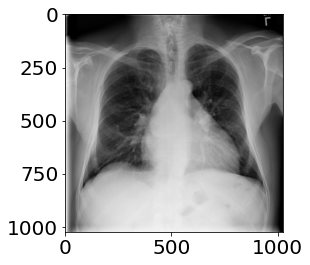

In [249]:
image_index_1 = 0

#image_orig_1 = Image.open(images_001_list[image_index_1])
image_orig_1 = load_img(images_001_list[image_index_1])

plt.imshow(image_orig_1, cmap='gray');

In [251]:
img_array = img_to_array(image_orig_1)
img_array

array([[[202., 202., 202.],
        [199., 199., 199.],
        [195., 195., 195.],
        ...,
        [  5.,   5.,   5.],
        [  2.,   2.,   2.],
        [  0.,   0.,   0.]],

       [[199., 199., 199.],
        [196., 196., 196.],
        [195., 195., 195.],
        ...,
        [  5.,   5.,   5.],
        [  2.,   2.,   2.],
        [  0.,   0.,   0.]],

       [[196., 196., 196.],
        [194., 194., 194.],
        [193., 193., 193.],
        ...,
        [  5.,   5.,   5.],
        [  2.,   2.,   2.],
        [  0.,   0.,   0.]],

       ...,

       [[255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.],
        ...,
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.]],

       [[255., 255., 255.],
        [255., 255., 255.],
        [254., 254., 254.],
        ...,
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.]],

       [[255., 255., 255.],
        [255., 255., 255.],
        [255., 2

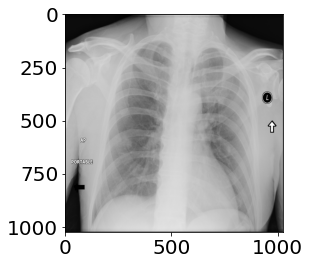

In [252]:
image_index_2 = 4

#image_orig_1 = Image.open(images_001_list[image_index_1])
image_orig_2 = load_img(images_001_list[image_index_2])

plt.imshow(image_orig_2, cmap='gray');

In [255]:
img_array2 = img_to_array(image_orig_2)
img_array2.shape

(1024, 1024, 3)

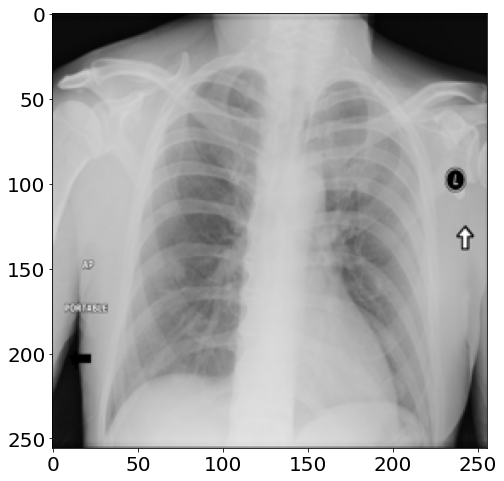

In [171]:
image_orig_1.size
width, height = image_orig_1.size  

newsize = (int(width/4), int(height/4))
im1 = image_orig_1.resize(newsize) 
plt.imshow(im1, cmap='gray')

In [172]:
#image_orig_1

In [173]:
# convert image to numpy array
data = asarray(image_orig_1)
#print(type(data))
# summarize shape
#print(data.shape)
print(data)

# create Pillow image
#image2 = Image.fromarray(data)
#print(type(image2))

# summarize image details
#print(image2.mode)
#print(image2.size)

[[[  5   5   5 255]
  [  8   8   8 255]
  [  8   8   8 255]
  ...
  [  8   8   8 255]
  [  9   9   9 255]
  [  5   5   5 255]]

 [[  9   9   9 255]
  [ 17  17  17 255]
  [ 16  16  16 255]
  ...
  [ 15  15  15 255]
  [ 16  16  16 255]
  [ 10  10  10 255]]

 [[  9   9   9 255]
  [ 16  16  16 255]
  [ 15  15  15 255]
  ...
  [ 15  15  15 255]
  [ 15  15  15 255]
  [ 11  11  11 255]]

 ...

 [[ 10  10  10 255]
  [ 18  18  18 255]
  [ 19  19  19 255]
  ...
  [ 67  67  67 255]
  [ 74  74  74 255]
  [ 46  46  46 255]]

 [[  5   5   5 255]
  [  9   9   9 255]
  [  9   9   9 255]
  ...
  [ 30  30  30 255]
  [ 34  34  34 255]
  [ 21  21  21 255]]

 [[  1   1   1 255]
  [  0   0   0 255]
  [  0   0   0 255]
  ...
  [  0   0   0 255]
  [  0   0   0 255]
  [  0   0   0 255]]]


In [174]:
data.shape

(1024, 1024, 4)

In [175]:
x_1 = asarray(im1)

In [176]:
#image_index_1 = 0

image_orig_1 = Image.open(images_001_list[4])#.convert("L")
#plt.imshow(image_orig_1, cmap='gray');
#img = PIL.Image.open("foo.jpg")
imgarr = np.array(image_orig_1) 
imgarr

array([[[  5,   5,   5, 255],
        [  8,   8,   8, 255],
        [  8,   8,   8, 255],
        ...,
        [  8,   8,   8, 255],
        [  9,   9,   9, 255],
        [  5,   5,   5, 255]],

       [[  9,   9,   9, 255],
        [ 17,  17,  17, 255],
        [ 16,  16,  16, 255],
        ...,
        [ 15,  15,  15, 255],
        [ 16,  16,  16, 255],
        [ 10,  10,  10, 255]],

       [[  9,   9,   9, 255],
        [ 16,  16,  16, 255],
        [ 15,  15,  15, 255],
        ...,
        [ 15,  15,  15, 255],
        [ 15,  15,  15, 255],
        [ 11,  11,  11, 255]],

       ...,

       [[ 10,  10,  10, 255],
        [ 18,  18,  18, 255],
        [ 19,  19,  19, 255],
        ...,
        [ 67,  67,  67, 255],
        [ 74,  74,  74, 255],
        [ 46,  46,  46, 255]],

       [[  5,   5,   5, 255],
        [  9,   9,   9, 255],
        [  9,   9,   9, 255],
        ...,
        [ 30,  30,  30, 255],
        [ 34,  34,  34, 255],
        [ 21,  21,  21, 255]],

       [[  1

In [177]:
img= np.array([[[155,  33, 129],
        [161, 218,   6]],

       [[215, 142, 235],
        [143, 249, 164]],

       [[221,  71, 229],
        [ 56,  91, 120]],

       [[236,   4, 177],
        [171, 105,  40]]])



In [178]:
img.shape

(4, 2, 3)

In [179]:
img.transpose()

array([[[155, 215, 221, 236],
        [161, 143,  56, 171]],

       [[ 33, 142,  71,   4],
        [218, 249,  91, 105]],

       [[129, 235, 229, 177],
        [  6, 164, 120,  40]]])

In [180]:
img.transpose(1,2,0)

array([[[155, 215, 221, 236],
        [ 33, 142,  71,   4],
        [129, 235, 229, 177]],

       [[161, 143,  56, 171],
        [218, 249,  91, 105],
        [  6, 164, 120,  40]]])

In [181]:
imgarr.transpose(2,0,1).reshape(65,-1)

ValueError: cannot reshape array of size 4194304 into shape (65,newaxis)

In [182]:
print(x_1.reshape(1,65536))

ValueError: cannot reshape array of size 262144 into shape (1,65536)

In [241]:
X = []
#X = array([[]], dtype=object)
for i in range(4):
    #image_index_1 = i
    print(i)

    image_orig_1 = Image.open(images_001_list[i])
    if i ==4:
        plt.imshow(image_orig_1, cmap='gray');
    #image_orig_1.size
    width, height = image_orig_1.size  
    #print(image_orig_1.size)
    newsize = (int(width/4), int(height/4))
    im1 = image_orig_1.resize(newsize) 
    #print(im1.size)
    #plt.imshow(im1, cmap='gray')
    x_i = asarray(im1)
    list(x_i)
    x_i=x_i.reshape(1,65536)
    print(x_i[0])
    #print(x_i.shape)
    X.append(list(x_i[0]))
X = asarray(X)
X.shape

0
[194 189 181 ...   7   0   0]
1
[205 204 202 ...   6   1   0]
2
[15 13 11 ... 92 60 25]
3
[119  90  80 ...  17  16  16]


(4, 65536)

In [238]:
X

array([[194, 189, 181, ...,   7,   0,   0],
       [205, 204, 202, ...,   6,   1,   0],
       [ 15,  13,  11, ...,  92,  60,  25],
       [119,  90,  80, ...,  17,  16,  16]], dtype=uint8)

In [198]:
df_Y = pd.DataFrame(Y, columns=["target"])

array([194, 189, 181, ...,   7,   0,   0], dtype=uint8)

In [210]:
X_train = []
for i in range(len(X)):
    temp_list = X[i][0]
    new_list
    j = [j for j in temp_list]
    #for j in rang
    #temp = X[i][0]
    print(temp.type())
    #temp=temp.reshape(1,65536)
    X_train.append(temp)
#X_train = [x for x in X_train]
#X_train

AttributeError: 'numpy.ndarray' object has no attribute 'type'

In [186]:
#patient_set = set(data_entry_df['Patient ID'])
#len(patient_set)

In [35]:
data_entry_df['Finding Labels']

0                   Cardiomegaly
1         Cardiomegaly|Emphysema
2          Cardiomegaly|Effusion
3                     No Finding
4                         Hernia
                   ...          
112115            Mass|Pneumonia
112116                No Finding
112117                No Finding
112118                No Finding
112119                No Finding
Name: Finding Labels, Length: 112120, dtype: object

In [37]:
all_labels

['Atelectasis',
 'Cardiomegaly',
 'Consolidation',
 'Edema',
 'Effusion',
 'Emphysema',
 'Fibrosis',
 'Hernia',
 'Infiltration',
 'Mass',
 'No Finding',
 'Nodule',
 'Pleural_Thickening',
 'Pneumonia',
 'Pneumothorax']

In [48]:
#data_entry_df['Finding Labels'] = data_entry_df['Finding Labels'].map(lambda x: x.replace('No Finding', ''))
all_labels = np.unique(list(chain(*data_entry_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
len(all_labels)
for current_label in all_labels:
    #if we find a non-empty label, map it to a separate column with a value '1' and leave '0' for the ones not found
    #so in the end we have an encoded array
    if(len(current_label)>1):
        data_entry_df[current_label] = data_entry_df['Finding Labels'].map(lambda found: 1 if current_label in found else 0)
data_entry_df.sample(25)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
7110,00001881_000.png,No Finding,0,1881,36,M,PA,2500,2048,0.168,...,0,0,0,0,0,1,0,0,0,0
22608,00005986_015.png,Pneumothorax,15,5986,33,M,PA,2048,2500,0.168,...,0,0,0,0,0,0,0,0,0,1
8567,00002268_000.png,No Finding,0,2268,59,M,PA,2992,2991,0.143,...,0,0,0,0,0,1,0,0,0,0
51224,00012935_021.png,Consolidation|Infiltration|Mass,21,12935,55,M,AP,2500,2048,0.168,...,0,0,0,1,1,0,0,0,0,0
33007,00008646_000.png,No Finding,0,8646,40,M,PA,2992,2991,0.143,...,0,0,0,0,0,1,0,0,0,0
46447,00011870_001.png,No Finding,1,11870,46,F,AP,2500,2048,0.168,...,0,0,0,0,0,1,0,0,0,0
75509,00018530_001.png,No Finding,1,18530,49,F,AP,3056,2544,0.139,...,0,0,0,0,0,1,0,0,0,0
23881,00006296_025.png,Infiltration,25,6296,15,F,AP,2500,2048,0.171,...,0,0,0,1,0,0,0,0,0,0
100981,00026818_016.png,Infiltration,16,26818,31,M,AP,3056,2544,0.139,...,0,0,0,1,0,0,0,0,0,0
61741,00015255_014.png,No Finding,14,15255,46,M,PA,2992,2991,0.143,...,0,0,0,0,0,1,0,0,0,0


In [49]:
diseases_df = data_entry_df[['Image Index','Effusion','Atelectasis','Cardiomegaly','Consolidation','Edema', 
                         'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration','Mass', 'Nodule', 'No Finding',
                          'Pleural_Thickening', 'Pneumonia','Pneumothorax'
                         ]]
diseases_df

,Image Index,Effusion,Atelectasis,Cardiomegaly,Consolidation,Edema,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,No Finding,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000001_000.png,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,00000001_001.png,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0
2,00000001_002.png,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3,00000002_000.png,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,00000003_000.png,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112115,00030801_001.png,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
112116,00030802_000.png,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
112117,00030803_000.png,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
112118,00030804_000.png,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [265]:
patient_train = diseases_df.iloc[:1000,1:].values.tolist()
patient_train

df_Y = pd.DataFrame(patient_train)[14]
df_Y df.columns = ['a', 'b']

0      [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
1      [0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...
2      [0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...
3      [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
4      [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...
                             ...                        
995    [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, ...
996    [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
997    [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
998    [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
999    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...
Name: 14, Length: 1000, dtype: object

In [264]:
df_Y["Target"] = df_Y[14]

In [65]:
from sklearn.neighbors import KNeighborsClassifier

In [66]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import misc
from PIL import Image

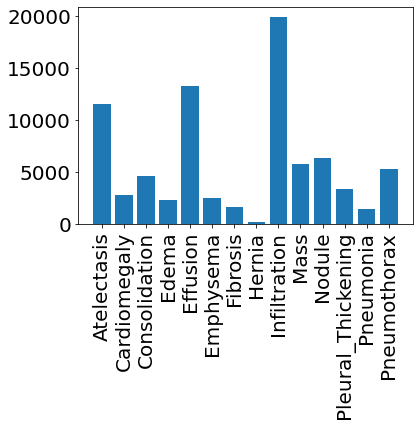

In [139]:
disease_counts = []

for l in all_labels:
    tempcount = (diseases_df[l] != 0).sum()
    disease_counts.append(tempcount)
    
diseases_counts_combined_df = []
for l,c in zip(all_labels,disease_counts):
    temp =(l,c)
    diseases_counts_combined_df.append(temp)
diseases_counts_combined_df

y_pos = np.arange(len(all_labels))
 
# Create bars
plt.bar(y_pos, disease_counts)
 
# Create names on the x-axis
plt.xticks(y_pos, all_labels, rotation = 90)
 
# Show graphic
plt.show()


In [46]:
given_labels = np.array(['Atelectasis', 'Cardiomegaly', 'Consolidation','Edema', 
                         'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration',
                         'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 
                         'Pneumothorax'])

d1 = dict((given_labels[i], i) for i in range(len(given_labels)))
#d1
d2 = dict(zip(data_entry_df['Image Index'], data_entry_df['Finding Labels']))
#d2
diseases = {k: v.split("|") for k, v in d2.items()}
#len(diseases.keys())




In [82]:
#diseases

In [43]:
#diseases_df = pd.DataFrame.from_dict(diseases, orient='index')
#diseases_df